In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Сравнение рейтингов Fandango с рейтингами других компаний

Теперь посмотрим, являлись ли рейтинги Fandango искусственно завышенными, чтобы продавать больше билетов.

**Объединим таблицу fandango с таблицей all_sites. Не каждый фильм в таблице Fandango найдётся в таблице all_sites, потому что некоторые фильмы Fandango имеют очень мало отзывов или вообще не имеют отзывов. Но можно сравнивать только те фильмы, которые есть в обеих таблицах. Поэтому сделайем объединение "*inner* merge" двух наборов данных, сопоставляя строки по колонке FILM.**

In [2]:
# Загрузить данные в DataFrame из csv-файла
fanDf = pd.read_csv('fandango_scrape.csv')
#fanDf.head(2)

In [3]:
# Загрузить данные в DataFrame из csv-файла
allDf = pd.read_csv('all_sites_scores.csv')
#allDf.sample(2)

In [4]:
# Объединение DataFrame'ов с помощью InnerJoin
df = pd.merge(
    fanDf,
    allDf,
    left_on='FILM',
    right_on='FILM',
    how='inner'
)
df.sample(2)

,FILM,STARS,RATING,VOTES,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Metacritic_user_vote_count,IMDB_user_vote_count
40,Pixels (2015),4.5,4.1,3886,17,54,27,5.3,5.6,246,19521
32,Night at the Museum: Secret of the Tomb (2014),4.5,4.1,5445,50,58,47,5.8,6.3,103,50291


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FILM                        145 non-null    object 
 1   STARS                       145 non-null    float64
 2   RATING                      145 non-null    float64
 3   VOTES                       145 non-null    int64  
 4   RottenTomatoes              145 non-null    int64  
 5   RottenTomatoes_User         145 non-null    int64  
 6   Metacritic                  145 non-null    int64  
 7   Metacritic_User             145 non-null    float64
 8   IMDB                        145 non-null    float64
 9   Metacritic_user_vote_count  145 non-null    int64  
 10  IMDB_user_vote_count        145 non-null    int64  
dtypes: float64(4), int64(6), object(1)
memory usage: 12.6+ KB


In [6]:
# Найти максимальные значения у числовых колонок
max_values = df.describe().transpose()['max']
max_values

STARS                              5.0
RATING                             4.8
VOTES                          34846.0
RottenTomatoes                   100.0
RottenTomatoes_User               94.0
Metacritic                        94.0
Metacritic_User                    9.6
IMDB                               8.6
Metacritic_user_vote_count      2375.0
IMDB_user_vote_count          334164.0
Name: max, dtype: float64

### Нормализация колонок до диапазона 0-5 в соответствии с колонками STARS и RATINGS от Fandango

Компании Rotten Tomatoes, Metacritic и IMDB используют другую шкалу измерения рейтингов, чем шкала от 0 до 5 звезд в Fandango. Чтобы выполнить сравнения, нужно *нормализовать* эти значения, чтобы они попадали с диапазон от 0 до 5 звёзд.

In [7]:
# Нормализация рейтингов
norm = np.round(df['RottenTomatoes']/20, 1)
df['RT_Norm'] = norm
#
norm = np.round(df['RottenTomatoes_User']/20, 1)
df['RTU_Norm'] = norm
#
norm = np.round(df['Metacritic']/20, 1)
df['Meta_Norm'] = norm
#
norm = np.round(df['Metacritic_User']/2, 1)
df['Meta_U_Norm'] = norm
#
norm = np.round(df['IMDB']/2, 1)
df['IMDB_Norm'] = norm

# Проверка
max_values = df.describe().transpose()['max']
max_values

STARS                              5.0
RATING                             4.8
VOTES                          34846.0
RottenTomatoes                   100.0
RottenTomatoes_User               94.0
Metacritic                        94.0
Metacritic_User                    9.6
IMDB                               8.6
Metacritic_user_vote_count      2375.0
IMDB_user_vote_count          334164.0
RT_Norm                            5.0
RTU_Norm                           4.7
Meta_Norm                          4.7
Meta_U_Norm                        4.8
IMDB_Norm                          4.3
Name: max, dtype: float64

**Создать DataFrame с названием norm_scores_df, в котором оставим только нормализованные рейтинги. Также оставим колонки STARS и RATING из исходной таблицы fandango.**

In [8]:
# Создать новый DataFrame
norm_scores_df = df[['STARS', 'RATING', 'RT_Norm', 'RTU_Norm', 'Meta_Norm', 'Meta_U_Norm', 'IMDB_Norm']]
norm_scores_df.sample(2)

,STARS,RATING,RT_Norm,RTU_Norm,Meta_Norm,Meta_U_Norm,IMDB_Norm
88,4.0,3.6,0.6,2.0,1.2,1.2,3.2
17,4.5,4.1,4.2,3.7,3.8,3.0,3.4


In [9]:
# Сохраним нормализованный DataFrame для дальнейшей работы (обучения)
fileName = 'my_norm_scores_df.csv'
# index=False: Не сохранять колонку с индексом. (по умолчанию True)
#norm_scores_df.to_csv(fileName, index=True)

### Сравнение распределений рейтингов от разных компаний

Теперь нужно ответить на главный вопрос. Действильно ли Fandango показывал неоправданно высокие рейтинги? Являются ли рейтинги в среднем более высокими, чем у других компаний?

**Построим график, сравнивающий распределения нормализованных рейтингов от всех компаний.**

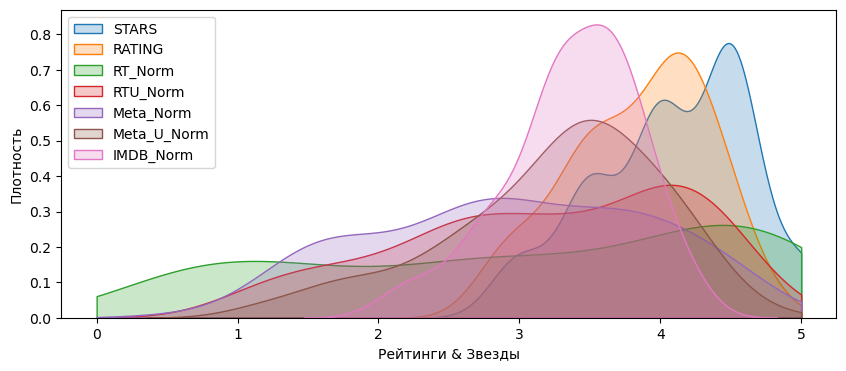

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), dpi=100)
# Несколько графиков на одной координатной оси
# Строим графики плотности распределения вероятности (сразу для всех колонок из DataFrame'a)
for col in list(norm_scores_df.columns):
    sns.kdeplot(
        data=norm_scores_df,
        x=col,
        # ограничить диапозон
        clip=[0, 5],
        fill=True,
        label=col
    )

plt.xlabel('Рейтинги & Звезды')
plt.ylabel('Плотность')
plt.legend(loc='upper left');

**Сразу видно, что рейтинги Fandango очень сдвинуты справо. Также хоршо заметно, что рейтинги RT от критиков имеют очень пологое распределение. Интересно будет сравнить только эти два распределения.**

**Построим график KDE plot, сравнивающий распределение рейтингов Rotten Tomatoes от критиков и распределение рейтингов STARS от Fandango.**

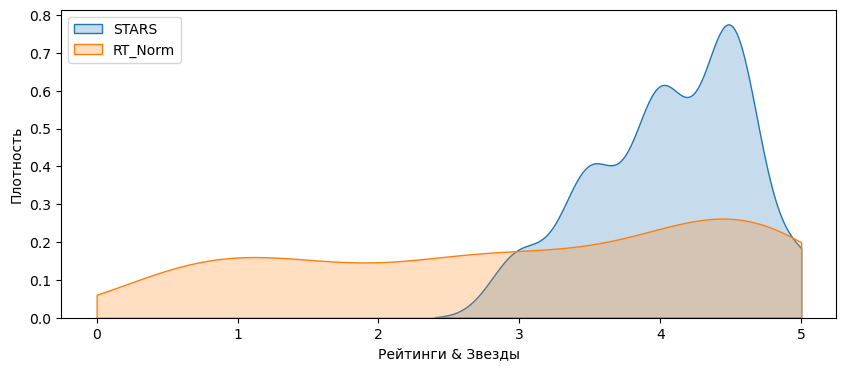

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), dpi=100)

sns.kdeplot(
    data=norm_scores_df['STARS'], label='STARS',
    clip=[0, 5], fill=True, ax=axes
)

sns.kdeplot(
    data=norm_scores_df['RT_Norm'], label='RT_Norm',
    clip=[0, 5], fill=True, ax=axes
)

plt.xlabel('Рейтинги & Звезды')
plt.ylabel('Плотность')
plt.legend(loc='upper left');

**Дополнительно для информации построим график histplot, сравнивающий все нормализованные рейтинги.**

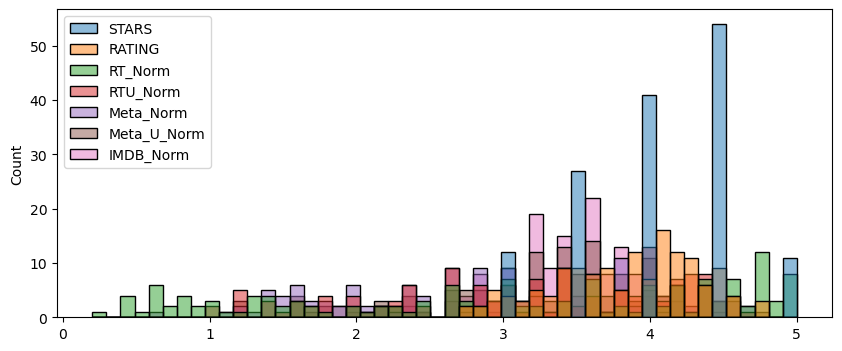

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), dpi=100)
sns.histplot(data=norm_scores_df, bins=50);

**Уже было видно, что рейтинги Fandango явно выше рейтингов других компаний, особенно если смотреть на округлённые вверх значения рейтингов. Теперь посмотрим на 10 фильмов с наихудшими рейтингами по версии Rotten Tomatoes Critic - какие это 10 фильмов? Какие нормализованные рейтинги дали этим фильмам другие компании? Здесь понадобится колонка FILM.**

# Создать новый DataFrame
norm_films_df = df[['FILM', 'STARS', 'RATING', 'RT_Norm', 'RTU_Norm', 'Meta_Norm', 'Meta_U_Norm', 'IMDB_Norm']]
norm_films_df.sample(2)

In [13]:
# 10 фильмов с наименьшими рейтингами по колонке 'RT_Norm'
worst_films = norm_films_df.nsmallest(10, 'RT_Norm')
worst_films

NameError: name 'norm_films_df' is not defined

**Посмотрим на графике распределение рейтингов от всех компаний для 10 фильмов с наихудшими рейтингами.**

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), dpi=100)
# Удалить колонку 'FILM' из DataFrame
worst_films2 = worst_films.drop('FILM', axis='columns')
# Строим графики плотности распределения вероятности (сразу для всех колонок из DataFrame'a)
for col in list(worst_films2.columns):
    sns.kdeplot(
        data=worst_films2,
        x=col,
        # ограничить диапозон
        clip=[0, 5],
        fill=True,
        label=col
    )

plt.xlabel('Рейтинги & Звезды')
plt.ylabel('Плотность')
plt.legend(loc='upper right');

---
----

<img src="https://upload.wikimedia.org/wikipedia/en/6/6f/Taken_3_poster.jpg">
  
**Выводы: явное завышение рейтингов! Fandango показывал 3-4 звезды для фильмов, которые явно были неудачными!**  
    
**Больше всего отличается фильм Taken 3 - Fandango дал ему рейтинг 4.5 звёзд, хотя этот фильм получил средний рейтинг 1.86 от других компаний!**

In [ ]:
norm_films_df.iloc[25]

In [14]:
(0.4+2.3+1.3+2.3+3) / 5

1.86